# Simulation 1

Vivek Gopalakrishnan | June 26, 2019


## Purpose

To determine if an edge is significantly different across 2 populations, should 
you use a T-test, the Mann Whitney U Test, or Fisher's Exact Test?


## Setup

- In this experiment, we use the indpendent edge (IE) model. 
- According to this model, the weight of each edge is given by an independent
Bernoulli randomn variable, i.e. $\Pr{(A_{ij} = 1)} = p_{ij}$. 
- The matrix of all $p_{ij}$'s is called the P matrix.
- We generate two samples from different IE models. Each model has a
symmetric P matrix with the same shape (therefore, each simulated graph
has the same number of nodes).


## Simulation

### Procedure

1. Let 
$\mathbf{b}$ be a vector of length $n$ linearly 
increasing over the range $[\epsilon, 1-\epsilon]$.

2. Let 
$\mathbf{P_1}$ be a grid determined by $\mathbf{b}$, i.e. 
$\mathbf{P_1}(1,1) = \mathbf{b}_1, \mathbf{P_1}(1,2) = \mathbf{b}_2, ...$ .

3. Let 
$
\mathbf{P_2}(u,v) = \begin{cases} 
    \mathbf{P_1}(u,v) + \delta \hspace{6mm} \text{if} \hspace{2mm} \mathbf{P_1}(u,v) < 0.5 \\
    \mathbf{P_1}(u,v) - \delta \hspace{6mm} \text{if} \hspace{2mm} \mathbf{P_1}(u,v) \geq 0.5
\end{cases}
$

4. Sample
$X_i \stackrel{iid}{\sim} \text{IE}(\mathbf{P_1})$ and 
$Y_i \stackrel{iid}{\sim} \text{IE}(\mathbf{P_2})$
for $i=1,...,m$.

Notice that $\mathbf{P_1} \in \mathbb{R}^{n \times n}$ 
and $\mathbf{P_2} \in \mathbb{R}^{n \times n}$.


## Testing

For each edge $ij$, 
1. Use the T-test to test the null hypothesis $\text{mean}(X_{ij}) = \text{mean}(Y_{ij})$
2. Use Kruskal-Wallis to test the null hypothesis $\text{median}(X_{ij}) = \text{median}(Y_{ij})$
3. Use Fisher's Exact Test to get the exact probability of observing any combination of edges

Plot the power versus $\mathbf{P}_{ij}$.

### Notes about Kruskal-Wallis
- Kruskal-Wallis is the multisample generalization of the 2-sample Mann-Whitney
U test.
- Kruskal-Wallis doesn't assume that the samples are paired like Wilcoxon does.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.utils import is_symmetric
from scipy.stats import ttest_ind, mannwhitneyu, fisher_exact

from src.simulations import IndependentEdge

%matplotlib inline

## Visualize the parameters and sample data

Plot the matrices $\mathbf{P_1}$ and $\mathbf{P_2}$ 
and plot the elements of $\mathbf{P_1}$ vs the elements of $\mathbf{P_2}$.

Plot the average connectome for each population 
$\bar{\mathbf{X}}$ and $\bar{\mathbf{Y}}$.
Also plot $\bar{\mathbf{Y}} - \bar{\mathbf{X}}$

In [2]:
ie = IndependentEdge(sample_size=100, n_vertices=10, epsilon=0.001, delta=0.05)

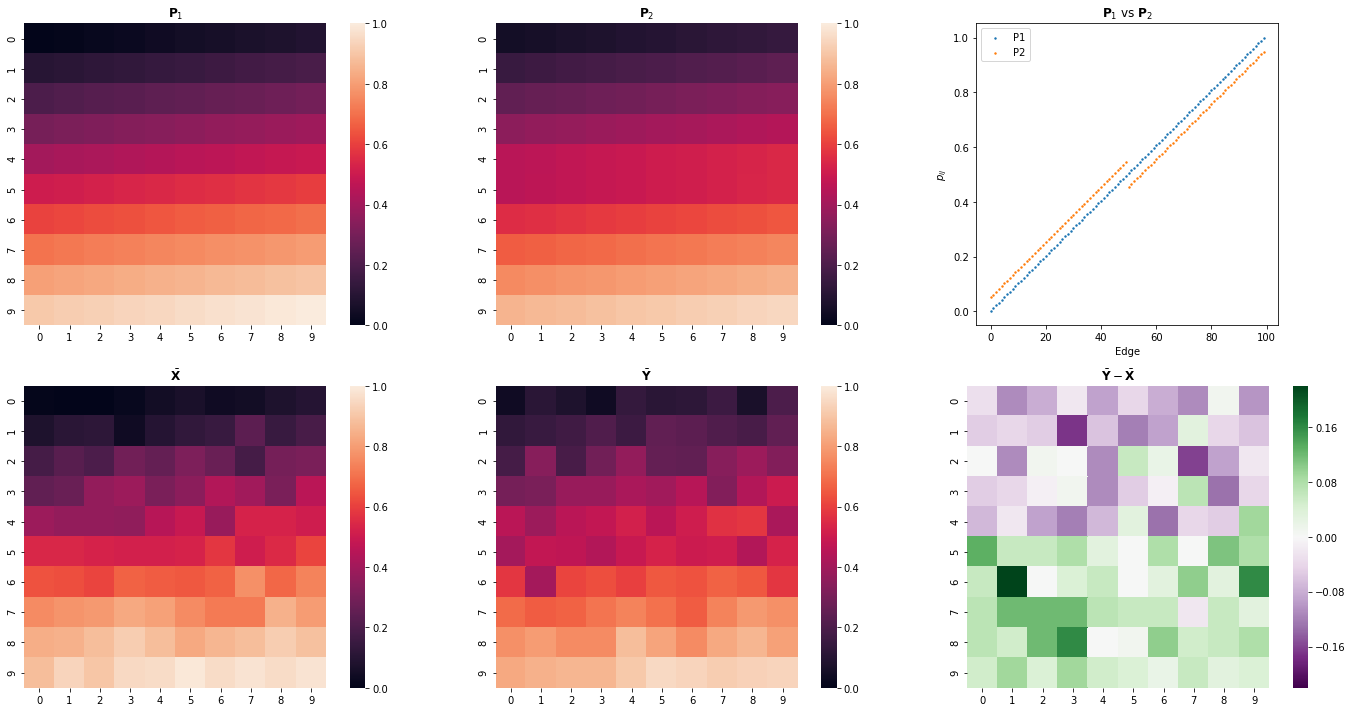

In [3]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10),)

# Draw the heatmaps
sns.heatmap(ie.p1, square=True, ax=ax[0, 0], vmin=0, vmax=1)
sns.heatmap(ie.p2, square=True, ax=ax[0, 1], vmin=0, vmax=1)
ax[0, 0].set(title=r"$\mathbf{P}_1$")
ax[0, 1].set(title=r"$\mathbf{P}_2$")

# Draw the scatterplot
y1 = ie.p1.flatten()
y2 = ie.p2.flatten()
x = range(len(y1))
ax[0, 2].scatter(x, y1, label="P1", s=2)
ax[0, 2].scatter(x, y2, label="P2", s=2)
ax[0, 2].legend()
ax[0, 2].set(title=r"$\mathbf{P}_1$ vs $\mathbf{P}_2$",
             xlabel="Edge", ylabel=r"$p_{ij}$")
x0, x1 = ax[0, 2].get_xlim()
y0, y1 = ax[0, 2].get_ylim()
ax[0, 2].set_aspect((x1-x0)/(y1-y0))

# Draw the average connectomes
x, y = ie._sample()
x_bar = np.mean(x, axis=0)
y_bar = np.mean(y, axis=0)

# X_bar
sns.heatmap(x_bar, square=True, ax=ax[1, 0], vmin=0, vmax=1)
ax[1, 0].set(title=r"$\bar{\mathbf{X}}$")

# Y_bar
sns.heatmap(y_bar, square=True, ax=ax[1, 1], vmin=0, vmax=1)
ax[1, 1].set(title=r"$\bar{\mathbf{Y}}$")

# Y_bar - X_bar
data = x_bar - y_bar
vmax = np.max(data)
vmin = np.min(data)
vmax = max(vmax, -vmin)
sns.heatmap(data, square=True, ax=ax[1, 2], cmap="PRGn", vmax=vmax, vmin=-vmax)
ax[1, 2].set(title=r"$\bar{\mathbf{Y}} - \bar{\mathbf{X}}$")

plt.tight_layout()

plt.savefig("power_parameters.png", dpi=300)
plt.show()

## Simulation 1

Estimate the power of the tests. Do this by making the null hypothesis false.

### Parameters
- Sample size: $m = 10$
- Number of vertices: $n = 10$
- $\epsilon = 0.001$
- $\delta = 0.05$

In [4]:
# Initialize generative class
ie = IndependentEdge(sample_size=10, n_vertices=10, epsilon=0.001, delta=0.05)

In [5]:
# Execute the simulation
pvals = ie.calculate_pvals(scipy_methods=[ttest_ind, mannwhitneyu, fisher_exact],
                           n_iter=100)

power = ie.calculate_proportion_positive(pvals)

100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


In [6]:
# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": power[0].flatten(),
    "mann-whitney": power[1].flatten(),
    "fisher": power[2].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "mann-whitney", "fisher"],
    var_name="test", 
    value_name="Power",
)

df.head()

,$p_{ij}$,test,Power
0,0.001000,t-test,0.00
1,0.011081,t-test,0.00
2,0.021162,t-test,0.00
3,0.031242,t-test,0.00
4,0.041323,t-test,0.01


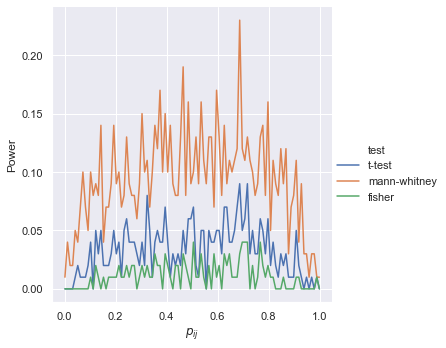

In [7]:
# Plot the power as a function of the connection strength
sns.set()
ax = sns.relplot(
    x=r"$p_{ij}$",
    y="Power",
    hue="test",
    data=df,
    legend="full",
    kind="line",
)
plt.show()

In this simulation, the power of the Mann Whitney U test is uniformly greater
than both the T-test and Fisher's Exact test. This means the Mann Whitney U
test has a higher probability of correctly rejecting a false null hypothesis.

From this simulation, the Mann Whitney test looks like the best choice
for this situation.

## Simulation 2

Estimate the Type 1 Error of the three tests. Do this by making the null hypothesis true.

### Parameters
- Sample size: $m = 100$
- Number of vertices: $n = 10$
- $\epsilon = 0.001$
- $\delta = 0$

In [8]:
# Initialize generative class
ie = IndependentEdge(sample_size=100, n_vertices=10, epsilon=0.001, delta=0)

In [9]:
# Execute the simulation
pvals = ie.calculate_pvals(scipy_methods=[ttest_ind, mannwhitneyu, fisher_exact],
                           n_iter=100)

type1 = ie.calculate_proportion_positive(pvals)

100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


In [10]:
# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": type1[0].flatten(),
    "mann-whitney": type1[1].flatten(),
    "fisher": type1[2].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "mann-whitney", "fisher"],
    var_name="test", 
    value_name="Type 1 Error",
)

df.head()

,$p_{ij}$,test,Type 1 Error
0,0.001000,t-test,0.00
1,0.011081,t-test,0.02
2,0.021162,t-test,0.03
3,0.031242,t-test,0.01
4,0.041323,t-test,0.03


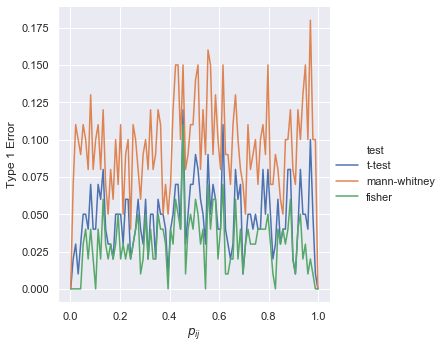

In [11]:
# Plot the power as a function of the connection strength
sns.set()
ax = sns.relplot(
    x=r"$p_{ij}$",
    y="Type 1 Error",
    hue="test",
    data=df,
    legend="full",
    kind="line",
)
plt.show()

Type 1 errror is the probability of rejecting a true null hypothesis. 
For a statistical test to be valid, the Type 1 error should be equal 
to the level alpha ($\alpha = 0.05$
in our case). 

- Clearly, the Type 1 error of the Mann Whitney U test vastly exceeds
this threshold, with an average Type 1 error of $0.1$. 
- The T-test appears to average out to around $0.05$, implying it is
valid in this situation. 
- Fisher's Exact Test has a slightly lower Type 1 error than the T-test,
implying that it is too conservative in this setting.

## Simulation 3

Compare the T-test to Boschloo's test.

### Estimate Power

In [12]:
# Initialize generative class
ie = IndependentEdge(sample_size=10, n_vertices=10, epsilon=0.001, delta=0.05)

# Execute the simulation
pvals = ie.calculate_pvals(scipy_methods=[ttest_ind], r_methods=["boschloo"], n_iter=100)
power = ie.calculate_proportion_positive(pvals)

100%|██████████| 100/100 [14:53<00:00,  9.32s/it]


In [13]:
# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": power[0].flatten(),
    "boschloo": power[1].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "boschloo",],
    var_name="test", 
    value_name="Power",
)
df.head()

,$p_{ij}$,test,Power
0,0.001000,t-test,0.00
1,0.011081,t-test,0.00
2,0.021162,t-test,0.00
3,0.031242,t-test,0.00
4,0.041323,t-test,0.02


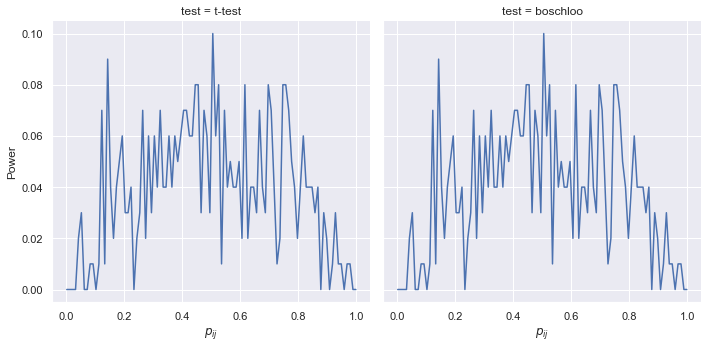

In [14]:
# Plot the power as a function of the connection strength
sns.set()
ax = sns.relplot(
    x=r"$p_{ij}$",
    y="Power",
    col="test",
    data=df,
    legend="full",
    kind="line",
)
plt.show()

The T-test and Boschloo's Tset appear identical in terms of Power.

### Estimate Type 1 Error

In [15]:
# Initialize generative class
ie = IndependentEdge(sample_size=10, n_vertices=10, epsilon=0.001, delta=0)

# Execute the simulation
pvals = ie.calculate_pvals(scipy_methods=[ttest_ind], r_methods=["boschloo"], n_iter=100)
type1 = ie.calculate_proportion_positive(pvals)

100%|██████████| 100/100 [14:20<00:00,  8.47s/it]


In [16]:
# Store the data in a Seaborn-compatible format
df = pd.DataFrame({
    r"$p_{ij}$": ie.p1.flatten(),
    "t-test": type1[0].flatten(),
    "boschloo": type1[1].flatten(),
}).melt(
    id_vars=[r"$p_{ij}$"], 
    value_vars=["t-test", "boschloo",],
    var_name="test", 
    value_name="Type 1 Error",
)
df.head()

,$p_{ij}$,test,Type 1 Error
0,0.001000,t-test,0.0
1,0.011081,t-test,0.0
2,0.021162,t-test,0.0
3,0.031242,t-test,0.0
4,0.041323,t-test,0.0


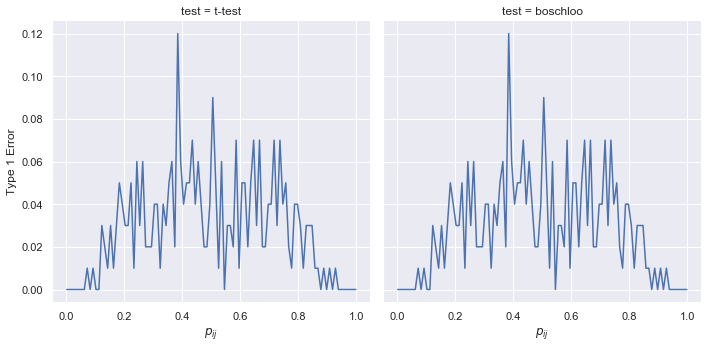

In [17]:
# Plot the power as a function of the connection strength
sns.set()
ax = sns.relplot(
    x=r"$p_{ij}$",
    y="Type 1 Error",
    col="test",
    data=df,
    legend="full",
    kind="line",
)
plt.show()

And again, they are equal in terms of Type 1 Error.

Boschloo's test is an adaptation Fisher's exact test. It is uniformly more powerful
than Fisher's as demonstrated here. However, from these simulations, it appears to be
equivalent to the T-test. Therefore, we default to using the T-test because it is 
implemented in many more languages and is more commonly understood.